# Exploratory analysis : NLP FOMC Project

In [126]:
#!pip install wordcloud

In [1]:
import numpy as np
import pandas as pd
from urllib import request
import bs4
from wordcloud import WordCloud, STOPWORDS 
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import re
import itertools
import datetime as dt

In [83]:
df1 = pd.read_csv("/Users/h2jw/Documents/GitHub/NLP-FOMC/lem_clean_version_8.csv", low_memory=True)

In [84]:
df1 = df1.drop(columns=['Unnamed: 0', 'index'])

In [85]:
df1.Date = df1.Date.astype('datetime64')
df1.statement = df1.statement.fillna("")
df1.statement = df1.statement.astype('str')
df1.chair_in_charge = df1.chair_in_charge.astype('str')
df1 = df1.dropna(axis=1)
df1[df1.Date.dt.year == 2015]

,Date,statement _size,statement,statement_number,chair_in_charge,score_academ,score_hostile,score_econo,score_virtue,score_vice,score_hawkish,score_posi,score_affi,score_uncert
126725,2015-03-18,738,good morning everybody know farewell luncheon ...,statement_0,CHAIR YELLEN,0.0,0.0,0.017291,0.014409,0.002882,0.0,0.500000,1.0,-0.005764
126726,2015-03-18,4,moved madam chair,statement_1,CHAIR YELLEN,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
126727,2015-03-18,17,thank without objection going call simon potte...,statement_2,CHAIR YELLEN,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
126728,2015-03-18,1467,1 thank madam chair splitting desk briefing tw...,statement_3,CHAIR YELLEN,0.0,0.0,0.041480,0.007848,0.013453,0.0,-0.565217,-1.0,-0.023543
126729,2015-03-18,3,questions president kocherlakota,statement_4,CHAIR YELLEN,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156077,2015-12-16,9,mean ask question,statement_2502,CHAIR YELLEN,0.0,0.0,0.000000,0.000000,0.000000,0.0,-1.000000,0.0,0.000000
156078,2015-12-16,25,opine bring discussion regarding instance rrp ...,statement_2503,CHAIR YELLEN,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
156079,2015-12-16,16,true need laughter,statement_2504,CHAIR YELLEN,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
156080,2015-12-16,54,change overnight rrp rate meeting something li...,statement_2505,CHAIR YELLEN,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [86]:
df1 = df1[df1['statement _size']!=0]
df1 = df1[df1.statement != ""]

Text(0.5, 1.0, 'Répartition des statements vides après nettoyage')

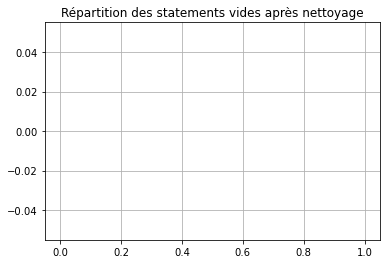

In [87]:
df_empty = df1[df1['statement']==""]
df_empty.hist('Date')
plt.title("Répartition des statements vides après nettoyage")

In [88]:
#df1.to_csv('update_version_7.csv')

In [89]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155081 entries, 0 to 156081
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              155081 non-null  datetime64[ns]
 1   statement _size   155081 non-null  int64         
 2   statement         155081 non-null  object        
 3   statement_number  155081 non-null  object        
 4   chair_in_charge   155081 non-null  object        
 5   score_academ      155081 non-null  float64       
 6   score_hostile     155081 non-null  float64       
 7   score_econo       155081 non-null  float64       
 8   score_virtue      155081 non-null  float64       
 9   score_vice        155081 non-null  float64       
 10  score_hawkish     155081 non-null  float64       
 11  score_posi        155081 non-null  float64       
 12  score_affi        155081 non-null  float64       
 13  score_uncert      155081 non-null  float64       
dtypes: d

In [90]:
df1.head()

,Date,statement _size,statement,statement_number,chair_in_charge,score_academ,score_hostile,score_econo,score_virtue,score_vice,score_hawkish,score_posi,score_affi,score_uncert
0,1976-08-17,41,ready start meeting morning first item busines...,statement_0,CHAIRMAN BURNS,0.0,0.04878,0.024390,0.048780,0.0,0.0,-1.0,1.0,-0.000000
1,1976-08-17,2,statementsee appendix,statement_1,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.000000
2,1976-08-17,27,alan think realignment currencies european com...,statement_2,CHAIRMAN BURNS,0.0,0.00000,0.037037,0.037037,0.0,0.0,1.0,1.0,-0.000000
3,1976-08-17,49,two alternatives one everybody goes floats sep...,statement_3,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,-1.0,-0.020408
4,1976-08-17,8,think would likely,statement_4,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.000000


## Preprocessing

La base s'arrête en 2014, on va rajouter le scrapping de 2015 avec les codes contenus dans `codes scrapping`.

In [10]:
# add 2015 update
df1.Date = df1.Date.astype('datetime64')

### Chairs

In [70]:
df = df1
pd.unique(df1.chair_in_charge)

array(['CHAIRMAN BURNS', 'CHAIRMAN MILLER', 'CHAIRMAN VOLCKER',
       'CHAIRMAN GREENSPAN', 'CHAIRMAN BERNANKE', 'CHAIR YELLEN'],
      dtype=object)

Text(0.5, 0, 'Chair person')

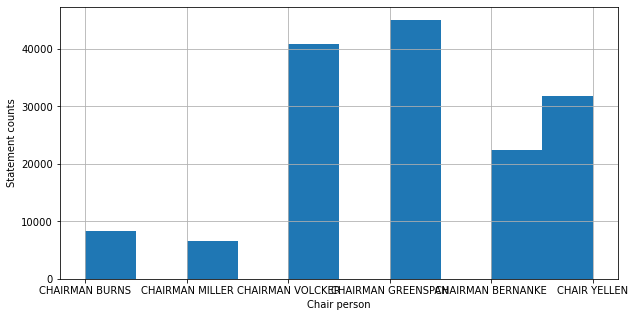

In [71]:
plt.figure(figsize=(10,5))
df['chair_in_charge'].hist()
plt.ylabel('Statement counts')
plt.xlabel('Chair person')

In [73]:
print(len(pd.unique(df['interlocutor_name'])), pd.unique(df['interlocutor_name'])[130:170])


KeyError: 'interlocutor_name'

In [14]:
def name_cleaning(name_list):
    # Removing punctuations in string
    # Using regex
    cleaned = []
    stopname_list=['CHAIRMAN', 'MS', 'VICE', 'MR']
    for name in name_list:
        res = re.sub(r'[^\w\s]', '', name)
        # printing result
        # print("The string after punctuation filter : " + res)
        
        res = ' '.join([word for word in res.split() if word not in stopname_list])
        cleaned.append(res)
    return cleaned
def get_role(name_list):
    role = []
    stopname_list=['CHAIRMAN', 'MS', 'VICE', 'MR']
    for name in name_list:
        res = re.sub(r'[^\w\s]', '', name)
        res = ' '.join([word for word in res.split() if word in stopname_list])
        role.append(res)
        
    return role

In [15]:
#df['role_int']= get_role(df.interlocutor_name.tolist())
df1['interlocutor_name']=name_cleaning(df.interlocutor_name.tolist())

In [16]:
pd.unique(df.interlocutor_name)[130:170]

array(['PATRIKIS', 'MULLINS', 'MCTEER', 'PROMISEL', 'MATTLINGLY', 'KELLY',
       'BROADDUS', 'HOENIG', 'PHILLIPS', 'MCDONOUGH', 'JORDAN', 'DANKER',
       'FISHER', 'WHITE', 'FORESTALL', 'BEEBE', 'MINEHAN', 'BLINDER',
       'YELLEN', 'CONRAD', 'MOSKOW', 'LANG', 'Mr', 'MOSCOW', 'KRIEGER',
       'KOS', 'MEYER', 'RIVLIN', '', 'MADIGAN', 'FERGUSON', 'GRAMLICH',
       'RIVES', 'POOLE', 'GILLUM', 'WHITESELL', 'VARVEL', 'SPILLENKOTHEN',
       'PARKINSON', 'MCDONUGH'], dtype=object)

In [17]:
df_small = df.head(40000)
df_small = df_small.groupby('interlocutor_name').agg({'statement':'count'})

<AxesSubplot:ylabel='statement'>

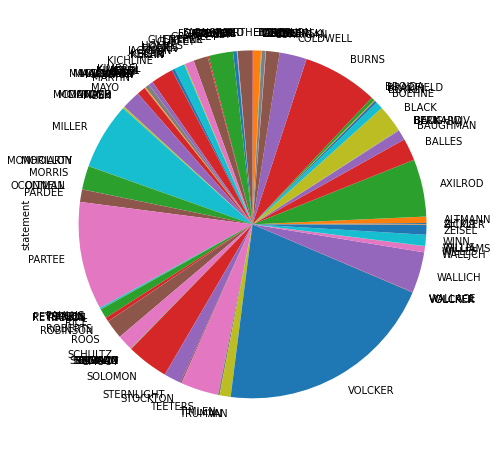

In [18]:
fig = plt.figure(figsize=(8,8))
fig.patch.set_facecolor('white')
df_small.statement.plot.pie()

### Statements

In [152]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.extend(['mr','re', 's', 'it', 'ex', 'in', 'he', 'and', 
             'there', 'however', 'to', 'now', 'to', 'of', 
             'the', 'they', 'but', 'soon', 'film', 'that',
             'who', 'of', 'dont', 'isnt', 'think', 'would', 'meet'])


[nltk_data] Downloading package stopwords to /Users/h2jw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
df1.head()

,Date,statement _size,statement,statement_number,chair_in_charge,score_academ,score_hostile,score_econo,score_virtue,score_vice,score_hawkish,score_posi,score_affi,score_uncert
0,1976-08-17,41,ready start meeting morning first item busines...,statement_0,CHAIRMAN BURNS,0.0,0.04878,0.024390,0.048780,0.0,0.0,-1.0,1.0,-0.000000
1,1976-08-17,2,statementsee appendix,statement_1,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.000000
2,1976-08-17,27,alan think realignment currencies european com...,statement_2,CHAIRMAN BURNS,0.0,0.00000,0.037037,0.037037,0.0,0.0,1.0,1.0,-0.000000
3,1976-08-17,49,two alternatives one everybody goes floats sep...,statement_3,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,-1.0,-0.020408
4,1976-08-17,8,think would likely,statement_4,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.000000


In [93]:
df=df1

On va "nettoyer" les statements des STOPWORDS.

In [153]:
df.statement = df.statement.fillna('')
df['statement'] = df['statement'].str.replace('[^\w\s]','') # remove punctuation

df["statement"] = df["statement"].str.lower().str.split() # get words with lowercase 

df['statement'] = df['statement'].apply(lambda x: [item for item in x if item not in stop]) # remove stopwords
df.statement.tail()

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_14230/2046776006.py:2: DeprecationWarning: invalid escape sequence \w
  df['statement'] = df['statement'].str.replace('[^\w\s]','') # remove punctuation
/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_14230/2046776006.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['statement'] = df['statement'].str.replace('[^\w\s]','') # remove punctuation


156077                                [mean, ask, question]
156078    [opine, bring, discussion, regarding, instance...
156079                               [true, need, laughter]
156080    [change, overnight, rrp, rate, meeting, someth...
156081                                              [thank]
Name: statement, dtype: object

In [155]:
df.statement = df.statement.astype('string')
df['statement'] = df['statement'].str.replace('[^\w\s]','')

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_14230/3591859878.py:2: DeprecationWarning: invalid escape sequence \w
  df['statement'] = df['statement'].str.replace('[^\w\s]','')
/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_14230/3591859878.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['statement'] = df['statement'].str.replace('[^\w\s]','')


In [156]:
#df.to_csv('cleaned_statement_version_8.csv')
df.statement[:10]

0    ready start meeting morning first item busines...
1                                statementsee appendix
2    alan realignment currencies european community...
3    two alternatives one everybody goes floats sep...
4                                               likely
5    know lot sentiment favor trying keep snake tog...
6    snake essentially political animal governments...
7                             realize assessment scott
8    small countries want continue snake feel stron...
9               alan making move swiss franc repayment
Name: statement, dtype: string

On va lemmatizer les mots. 

In [101]:
from nltk.stem import WordNetLemmatizer 
from itertools import groupby
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from gensim.parsing.preprocessing import STOPWORDS
lemmatizer = WordNetLemmatizer() 

In [98]:
def stem_tfidf(statement):
    lemmatize_list=""
    final_list = list()
    intermed_list = statement.lower().split()
    for ele in intermed_list:
        if (ele not in STOPWORDS) and (ele not in stop_words) :
            final_list.append(ele)
        else:
            pass
    final_list = list(filter(None, final_list))
    for ele in final_list:
        lemmatize_list += " "+lemmatizer.lemmatize(ele) 
    
    return lemmatize_list

def colloquial_transformation(statement):
    
    """ NLTK POS TAGGER : 
        find the list of abbreviations here : https://medium.com/@muddaprince456/categorizing-and-pos-tagging-with-nltk-python-28f2bc9312c3
        
        Js = JJR or JJR or JJS
        Ns = NN or NNP or NNS or NNPS 
        
        Colloquial combinations according to Justeson and Katz (1995) :
            - Js+Ns
            - Js*2+Ns
            - Ns*2
            - Js+Ns*2
            - Ns+Js+Ns
            - Ns*3
            - Ns+IN+Ns
            
        Returns list of colloquials
    """
    
    text = word_tokenize(statement)
    POS = nltk.pos_tag(text)
    colloquial=[]
    pos_list=[]
    for i, pos in enumerate(POS[1:len(POS)-1]):
        word, tag = pos
        bw, btag = POS[i-1]
        try:
            aw, atag = POS[i+1]
        except:
            pass
       
        if ('NN' in tag) and ('NN' in atag) and ('NN' in btag):
            colloquial.append(bw+' '+word+' '+aw)
            pos_list.append(pos)
        elif ('JJ' in btag) and ('NN' in tag) and ('JJ' in atag):
            colloquial.append(bw+' '+word+' '+aw)
            pos_list.append(pos)
        elif ('NN' in btag) and ('JJ' in tag) and ('NN' in atag):
            colloquial.append(bw+' '+word+' '+aw)
            pos_list.append(pos)
        elif ('JJ' in btag) and ('JJ' in tag) and ('NN' in atag):
            colloquial.append(bw+' '+word+' '+aw)
            pos_list.append(pos)
        elif ('NN' in btag) and ('IN' in tag) and ('NN' in atag):
            colloquial.append(bw+' '+word+' '+aw)
            pos_list.append(pos)
        elif ('NN' in tag) and ('NN' in atag) :
            colloquial.append(word+' '+aw)
            pos_list.append(pos)
        elif ('JJ' in tag) and ('NN' in atag) :
            colloquial.append(word+' '+aw)
            pos_list.append(pos)
        else :
            pass
    return colloquial, pos_list


def get_freq_two_three(statement):
    """ Gets the colloquials whose frequency are above 100 """
    final_col, final_pos = [],[]
    col_list, pos_list =colloquial_transformation(statement)
    freq = [len(list(group)) for key, group in groupby(col_list)]
    for idx in range(len(freq)):
        if freq[idx] >= 100:
            final_col.append(col_list[idx])
            final_pos.append(pos_list[idx])
        else : 
            pass
    return final_col, final_pos


def plot_freq_colloquial(list_statement):
    """ Plots colloquial sentences' frequency distributions """
    # Concaténer tous les statements
    statement = ""
    for s in list_statement:
        statement += " "+s
    col_list, pos_list = colloquial_transformation(statement)
    freq = [len(list(group)) for key, group in groupby(col_list)]
    fig = plt.figure()
    plt.title("Colloquial frequency distribution")
    plt.hist(freq)
    plt.plot()

def replace_words_by_colloquials(statement):
    """ Replaces in statement the individual words by colloquial sentences """
    text = word_tokenize(statement)
    new_text=""
    col, pos = get_freq_two_three(statement)
    for idx, word in enumerate(text):
        if (idx in pos) :
            ind = pos.index(idx)# two-words colloquial
            if len(col[ind].split())==2:
                new_text+=" "+col[ind]
            elif len(col[ind].split())==3: #three-words colloquial
                new_text+= " "+col[ind]
        else :
            new_text+= " "+word
    return new_text 
                    

In [ ]:
df = df.reset_index()
lem_list =[]
for i in trange(len(df.statement)):
    statement = str(df.statement.iloc[[i]][i])
    try:
        statement = stem_tfidf(statement)
    except: 
        pass
    clean_statement = replace_words_by_colloquials(statement)
    lem_list.append(clean_statement)

df['lemmatized'] = lem_list

In [ ]:
#df.to_csv('lem_clean_version_8.csv')

In [24]:
df1 = pd.read_csv("/Users/h2jw/Documents/GitHub/NLP-FOMC/lem_clean_version_8.csv", low_memory=True)
df1 = df1.drop(columns=['Unnamed: 0', 'index'])

In [31]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156082 entries, 0 to 156081
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date               156082 non-null  object 
 1   interlocutor_name  156080 non-null  object 
 2   statement _size    156082 non-null  int64  
 3   statement          155081 non-null  object 
 4   statement_number   156082 non-null  object 
 5   chair_in_charge    156082 non-null  object 
 6   score_academ       156082 non-null  float64
 7   score_hostile      156082 non-null  float64
 8   score_econo        156082 non-null  float64
 9   score_virtue       156082 non-null  float64
 10  score_vice         156082 non-null  float64
 11  score_hawkish      156082 non-null  float64
 12  score_posi         156082 non-null  float64
 13  score_affi         156082 non-null  float64
 14  score_uncert       156082 non-null  float64
 15  lemmatized         153982 non-null  object 
dtypes:

In [32]:
df1.Date = df1.Date.astype('datetime64')
df1.lemmatized = df1.lemmatized.astype('str')
df1.statement = df1.statement.fillna("")

In [34]:
df1.head()

,Date,interlocutor_name,statement _size,statement,statement_number,chair_in_charge,score_academ,score_hostile,score_econo,score_virtue,score_vice,score_hawkish,score_posi,score_affi,score_uncert,lemmatized
0,1976-08-17,BURNS,41,ready start meeting morning first item busines...,statement_0,CHAIRMAN BURNS,0.0,0.04878,0.024390,0.048780,0.0,0.0,-1.0,1.0,-0.000000,ready start meeting morning item business act...
1,1976-08-17,HOLMES,2,statementsee appendix,statement_1,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.000000,statementsee appendix
2,1976-08-17,BLACK,27,alan think realignment currencies european com...,statement_2,CHAIRMAN BURNS,0.0,0.00000,0.037037,0.037037,0.0,0.0,1.0,1.0,-0.000000,alan think realignment currency european comm...
3,1976-08-17,HOLMES,49,two alternatives one everybody goes floats sep...,statement_3,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,-1.0,-0.020408,alternative everybody go float separately sec...
4,1976-08-17,BLACK,8,think would likely,statement_4,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.000000,think likely


## Quelques statistiques descriptives...

- Wordclouds par "Chair in charge"

In [157]:
def nuage_de_mots(text): 
    wordcloud = WordCloud(background_color="white",
                          relative_scaling = 1.0,
                          width=1280, 
                          height=800, 
                          stopwords = STOPWORDS # mots à ne pas prendre en compte dans le nuage
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()   
    

In [159]:
df.statement

0         ready start meeting morning first item busines...
1                                     statementsee appendix
2         alan realignment currencies european community...
3         two alternatives one everybody goes floats sep...
4                                                    likely
                                ...                        
156077                                    mean ask question
156078    opine bring discussion regarding instance rrp ...
156079                                   true need laughter
156080    change overnight rrp rate meeting something li...
156081                                                thank
Name: statement, Length: 155081, dtype: string

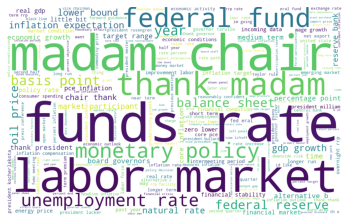

Wordcloud associé à la chair Yellen


In [160]:
df_statement = df.groupby('chair_in_charge')['statement'].apply(' '.join)
nuage_de_mots(df_statement.iloc[[0]][0])  
print("Wordcloud associé à la chair Yellen")

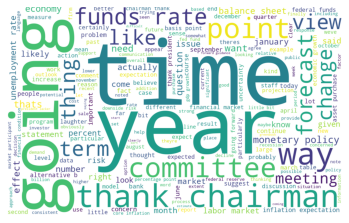

Wordcloud associé à la chair Bernanke


In [161]:
nuage_de_mots(df_statement.iloc[[1]][0]) 
print("Wordcloud associé à la chair Bernanke")

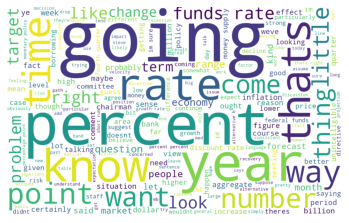

Wordcloud associé à la chair Volcker


In [162]:
nuage_de_mots(df_statement.iloc[[-1]][0]) 
print("Wordcloud associé à la chair Volcker")

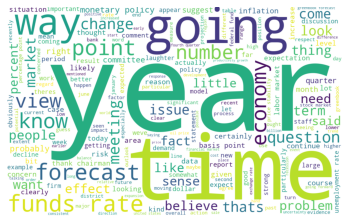

Wordcloud associé à la chair Greenspan


In [163]:
nuage_de_mots(df_statement.iloc[[3]][0]) 
print("Wordcloud associé à la chair Greenspan")

Most used words

In [109]:
from collections import Counter
count_words = pd.DataFrame({'counter' : df
    .groupby('chair_in_charge')
    .apply(lambda s: ' '.join(s['statement']).split())
    .apply(lambda s: Counter(s))
    .apply(lambda s: s.most_common())
    .explode()}
)
count_words[['word','count']] = pd.DataFrame(count_words['counter'].tolist(), index=count_words.index)


KeyboardInterrupt: 

In [143]:
per_chair = count_words.groupby(['chair_in_charge'])['count'].sum()
per_chair

chair_in_charge
CHAIR YELLEN          3260616
CHAIRMAN BERNANKE     2050731
CHAIRMAN BURNS         231348
CHAIRMAN GREENSPAN    2393051
CHAIRMAN MILLER        165542
CHAIRMAN VOLCKER       911297
Name: count, dtype: int64

In [151]:
count_words.sort_values(by='count').tail(10)


,chair_in_charge,counter,word,count
5,CHAIR YELLEN,"(policy, 20955)",policy,20955
4,CHAIR YELLEN,"(percent, 22428)",percent,22428
18650,CHAIRMAN BERNANKE,"(would, 22742)",would,22742
18649,CHAIRMAN BERNANKE,"(think, 23700)",think,23700
3,CHAIR YELLEN,"(think, 25858)",think,25858
69335,CHAIRMAN GREENSPAN,"(think, 27815)",think,27815
69334,CHAIRMAN GREENSPAN,"(would, 28482)",would,28482
2,CHAIR YELLEN,"(would, 28673)",would,28673
1,CHAIR YELLEN,"(inflation, 31428)",inflation,31428
0,CHAIR YELLEN,"(rate, 34704)",rate,34704


We add "think" and "would" to the stopwords list. 

### Tests de LDA 
#### Approche *bag of words*
- LDA sur l'ensemble des statements. 
- LDA sur Chair Burns, Chair Miller et Chair Greenspan

On a considéré comme document l'ensemble des statements ou l'ensemble des statements prononcé sous une chair (Burns, Miller ou Greenspan). 


In [183]:
#!pip install pyldavis

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn


def LDA_fit(series, n_topic): #notre LDA prend en entrée le series.dataframe contenant l'information textuelle 
                                      #et le nombre de topic à modéliser
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=1000)
    tfidf = tfidf_vectorizer.fit_transform(series)

    lda = LatentDirichletAllocation(n_components=n_topic, max_iter=5,
                                  learning_method='online',
                                  learning_offset=50.,
                                  random_state=0)
    lda.fit(tfidf)
    LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=n_topic, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

    tf_feature_names = tfidf_vectorizer.get_feature_names()

    return pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vectorizer)



def LDA_on_dataset(series, n_topic): #notre LDA prend en entrée le series.dataframe contenant l'information textuelle 
                                      #et le nombre de topic à modéliser
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=1000)
    tfidf = tfidf_vectorizer.fit_transform(series)

    lda = LatentDirichletAllocation(n_components=n_topic, max_iter=5,
                                  learning_method='online',
                                  learning_offset=50.,
                                  random_state=0)
    lda.fit_transform(tfidf)
    LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=n_topic, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

    tf_feature_names = tfidf_vectorizer.get_feature_names()

    return pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vectorizer)



In [43]:
print('Statement : \n')
pyLDAvis.enable_notebook()
LDA_fit(df1.lemmatized, 5)

Statement : 



/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.217955 -0.036006       1        1  69.669520
0      0.299241 -0.143639       2        1   9.167079
3     -0.135889  0.286436       3        1   8.162972
1     -0.328104 -0.305829       4        1   6.663499
4     -0.053204  0.199038       5        1   6.336930, topic_info=            Term          Freq         Total Category  logprob  loglift
905        thank  13365.000000  13365.000000  Default  30.0000  30.0000
655    president  13245.000000  13245.000000  Default  29.0000  29.0000
692     question   6454.000000   6454.000000  Default  28.0000  28.0000
364     governor   6549.000000   6549.000000  Default  27.0000  27.0000
993          yes   4940.000000   4940.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
33   alternative    375.832042   1197.294204   Topic5  -4.3898   1.6001
123       change    512.986389   1880.363745   Topic5  -4.0787   1.4598
886        table    231.967619    699.454214   Topic5  -4.8723   1.6551
668      problem    195.231886    760.333364   Topic5  -5.0447   1.3992
964         want    238.794254   2243.983245   Topic5  -4.8433   0.5184

[244 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.469345         10
0         5  0.528688         10
29        1  0.533683      agree
29        4  0.465081      agree
30        1  0.330468  agreement
...     ...       ...        ...
993       3  0.999786        yes
997       1  0.252783      youre
997       2  0.746349      youre
998       1  0.418366      youve
998       2  0.581202      youve

[328 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2, 5])

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [45]:
df_burns = df1[df1.chair_in_charge == 'CHAIRMAN BURNS']
df_miller = df1[df1.chair_in_charge == 'CHAIRMAN MILLER']

In [53]:
print('Statement Burns : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_burns.statement, 5)

Statement Burns : 



/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.119885  0.009299       1        1  58.621198
0      0.127002 -0.028044       2        1  18.501046
1     -0.370716  0.075364       3        1   9.325377
3     -0.011561 -0.258937       4        1   6.930199
4      0.135390  0.202318       5        1   6.622181, topic_info=            Term        Freq       Total Category  logprob  loglift
895        thank  293.000000  293.000000  Default  30.0000  30.0000
646       please  254.000000  254.000000  Default  29.0000  29.0000
994          yes  265.000000  265.000000  Default  28.0000  28.0000
967         well  340.000000  340.000000  Default  27.0000  27.0000
896        thats  245.000000  245.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
704        range   35.238459  118.344577   Topic5  -3.8937   1.5033
525       market   38.011352  140.480049   Topic5  -3.8179   1.4076
989        would   39.574714  333.062935   Topic5  -3.7776   0.5846
435  information   13.319890   34.942152   Topic5  -4.8665   1.7503
903        think   13.417183  315.432457   Topic5  -4.8593  -0.4427

[264 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2         1  0.509647  accept
2         5  0.467177  accept
7         1  0.102189     act
7         2  0.868609     act
24        2  0.877729  agency
...     ...       ...     ...
996       1  0.460650     yet
996       5  0.514844     yet
998       1  0.473751   youre
998       2  0.033839   youre
998       5  0.473751   youre

[411 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4, 5])

In [46]:
print('Statement Miller : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_miller.lemmatized, 5)

Statement Miller : 



/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.105667 -0.029689       1        1  63.447973
1      0.154023 -0.166222       2        1  10.553953
4      0.265414  0.122537       3        1   9.457811
3     -0.153138  0.230599       4        1   8.370439
0     -0.160632 -0.157225       5        1   8.169823, topic_info=             Term        Freq       Total Category  logprob  loglift
992           yes  265.000000  265.000000  Default  30.0000  30.0000
896         thats  197.000000  197.000000  Default  29.0000  29.0000
755         right  162.000000  162.000000  Default  28.0000  28.0000
895         thank  226.000000  226.000000  Default  27.0000  27.0000
563           nan  154.000000  154.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
371          good   15.744248   45.942832   Topic5  -4.5457   1.4338
75        average   12.563823   27.733796   Topic5  -4.7714   1.7129
453  intervention   11.563168   25.566733   Topic5  -4.8544   1.7113
413            id   12.950153   65.306936   Topic5  -4.7411   0.8867
901         think   13.586147  244.703528   Topic5  -4.6931  -0.3863

[249 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2         1  0.129641     absence
2         2  0.129641     absence
2         5  0.648203     absence
3         1  0.125408  absolutely
3         4  0.815152  absolutely
...     ...       ...         ...
995       5  0.717484        youd
996       1  0.173719       youll
996       2  0.781737       youll
997       1  0.291611       youre
997       4  0.680426       youre

[379 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 4, 1])

In [256]:
df_greenspan = df_lda[df_lda.chair_in_charge == 'CHAIRMAN GREENSPAN']

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [257]:
print('Statement Greenspan : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_greenspan.cleaned_statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement Miller : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.193199  0.015443       1        1  40.456062
0      0.209096  0.008848       2        1  39.608957
3     -0.197378 -0.381319       3        1   6.860028
4      0.155182  0.094060       4        1   6.764059
2     -0.360099  0.262967       5        1   6.310895, topic_info=           Term         Freq        Total Category  logprob  loglift
645   president  4998.000000  4998.000000  Default  30.0000  30.0000
358    governor  2965.000000  2965.000000  Default  29.0000  29.0000
747       right  1108.000000  1108.000000  Default  28.0000  28.0000
886       thank  1075.000000  1075.000000  Default  27.0000  27.0000
887        that   997.000000   997.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
744     revised     0.283578    46.598261   Topic5 -10.4362  -2.3389
991         yes     0.289667  1034.924273   Topic5 -10.4150  -5.4182
949        vice     0.288644   416.676684   Topic5 -10.4185  -4.5120
224  discussion     0.287930   296.978092   Topic5 -10.4210  -4.1758
313       first     0.286796   389.133965   Topic5 -10.4249  -4.4500

[287 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
10        1  0.925301  activity
10        2  0.071177  activity
22        1  0.066081     agree
22        2  0.451174     agree
22        3  0.480797     agree
...     ...       ...       ...
991       2  0.096625       yes
997       1  0.123265       you
997       2  0.876551       you
998       2  0.984522     youre
998       5  0.009467     youre

[461 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 3])

On va chercher à observer/mesurer l'impact d'un changement de chair sur un membre ayant fait plusieurs chairs.

Les chairs se succèdent selon la temporalité suivante : 
- 08/1976 : Chair Burns
- 01/1978 : Chair Miller
- 08/1979 : Chair Volcker
- 08/1987 : Chair Greenspan
- 08/2006 : Chair Bernanke
- 01/2014 : Chair Yellen

Observons arbitrairement les individus tandem entre la chair Volcker et la chair Greenspan puis chair Bernanke et chair Greenspan. 

In [662]:
df.chair_in_charge = df.chair_in_charge.astype('string')
#df.Date = df.Date.astype('datetime64')

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sélection des statements de la chair Volcker et de la chair Greenspan. 

In [65]:
mask = (df.chair_in_charge == "CHAIRMAN VOLCKER") + (df.chair_in_charge == "CHAIRMAN GREENSPAN")
df1  = df[mask]
df1

,Date,interlocutor_name,statement _size,statement,statement_number,chair_in_charge,score_academ,score_hostile,score_econo,score_virtue,...,Yes,No,Negate,SureLw,If,NotLw,RspGain,ABS,Causal,role_int
15170,1979-08-14,VOLCKER,636,might say benefit come little executive sessio...,statement_0,CHAIRMAN VOLCKER,0.007862,0.022013,0.036164,0.051887,...,0.009434,0.000000,0.006289,0.034591,0.018868,0.004717,0.001572,0.034591,0.020440,CHAIRMAN
15171,1979-08-14,WALLICH,21,possible figure unrealized gain loss account t...,statement_1,CHAIRMAN VOLCKER,0.000000,0.000000,0.095238,0.000000,...,0.000000,0.000000,0.047619,0.047619,0.095238,0.000000,0.000000,0.000000,0.095238,MR
15172,1979-08-14,FARNSWORTH,25,governor wallich today dave robinson manager a...,statement_2,CHAIRMAN VOLCKER,0.000000,0.080000,0.040000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,MR
15173,1979-08-14,VOLCKER,11,account talking domestic foreign,statement_3,CHAIRMAN VOLCKER,0.000000,0.000000,0.090909,0.000000,...,0.000000,0.000000,0.090909,0.090909,0.181818,0.000000,0.000000,0.000000,0.090909,CHAIRMAN
15174,1979-08-14,WALLICH,35,domestic foreign side take rule fasb requires ...,statement_4,CHAIRMAN VOLCKER,0.000000,0.000000,0.000000,0.028571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,MR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101794,2006-01-31,GREENSPAN,28,gather correctly theres real interest reversin...,statement_164,CHAIRMAN GREENSPAN,0.000000,0.035714,0.071429,0.035714,...,0.000000,0.035714,0.035714,0.035714,0.035714,0.035714,0.000000,0.071429,0.071429,CHAIRMAN
101795,2006-01-31,DANKER,185,thank chairman decision go ahead status quo wa...,statement_165,CHAIRMAN GREENSPAN,0.010811,0.005405,0.048649,0.021622,...,0.054054,0.000000,0.005405,0.059459,0.010811,0.000000,0.000000,0.032432,0.016216,MS
101796,2006-01-31,GREENSPAN,19,request federal reserve board engage addressin...,statement_166,CHAIRMAN GREENSPAN,0.052632,0.000000,0.105263,0.052632,...,0.000000,0.000000,0.052632,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,CHAIRMAN
101797,2006-01-31,GREENSPAN,27,federal reserve board voted unanimously accept...,statement_167,CHAIRMAN GREENSPAN,0.037037,0.000000,0.074074,0.037037,...,0.000000,0.000000,0.037037,0.037037,0.000000,0.000000,0.000000,0.037037,0.037037,CHAIRMAN


Sélection des individus ayant prononcé des statements sur les deux chair.

In [131]:
df1['Date_max']= df1.Date
df1.assign(Date_max=df1.Date)
df_interlocutor = df1.groupby('interlocutor_name').agg({'Date':'min', 'Date_max':'max', 'statement':' '.join})

/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_22816/1127751381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date_max']= df1.Date


In [67]:
df_interlocutor.head()


,Date,Date_max,statement
interlocutor_name,,,
,1996-12-17,1997-09-30,president jordan last time looked issue year a...
ALEXANDER,1999-02-03,1999-02-03,main changes forecast international side drive...
ALTMA,1979-09-18,1979-10-06,chairman volcker yes president balles presiden...
ALTMANN,1979-08-14,1982-12-21,yes change authorization foreign currency oper...
ANGELL,1986-02-12,1993-12-21,hesitate make governor seger incorrect point f...


In [68]:
df_interlocutor.Date = df_interlocutor.Date.astype('datetime64')
df_interlocutor.Date_max = df_interlocutor.Date_max.astype('datetime64')

In [97]:
mask_volcker = (df_interlocutor.Date.dt.strftime('%Y-%m') >= '1979-08') & (df_interlocutor.Date_max.dt.strftime('%Y-%m') < '1987-08')
mask_greenspan = (df_interlocutor.Date.dt.strftime('%Y-%m') >= '1987-08') & (df_interlocutor.Date_max.dt.strftime('%Y-%m') < '2006-08')
mask_tandem = (df_interlocutor.Date.dt.strftime('%Y-%m') <= '1987-08') & (df_interlocutor.Date_max.dt.strftime('%Y-%m')< "2006-08")
df_volcker = df_interlocutor[mask_volcker]
df_greenspan = df_interlocutor[mask_greenspan]
df_tandem = df_interlocutor[mask_volcker & mask_greenspan]



In [93]:
df_volcker['length']=df_volcker['Date_max']-df_volcker['Date']
df_volcker['statement_size']=df_volcker.statement.str.len()
df_greenspan['length']=df_greenspan['Date_max']-df_greenspan['Date']
df_greenspan['statement_size']=df_greenspan.statement.str.len()


/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_22816/2953080828.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_volcker['length']=df_volcker['Date_max']-df_volcker['Date']
/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_22816/2953080828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_volcker['statement_size']=df_volcker.statement.str.len()
/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_22816/2953080828.py:3: SettingWithCopyWarning: 
A value is trying to be se

In [94]:
df_yellen.sort_values(by='length', ascending=False).head()

,Date,interlocutor_name,statement _size,statement,statement_number,chair_in_charge,score_academ,score_hostile,score_econo,score_virtue,...,SureLw,If,NotLw,RspGain,ABS,Causal,role_int,Date_max,length,statement_size


Text(0.5, 1.0, 'Volcker')

<Figure size 1440x720 with 0 Axes>

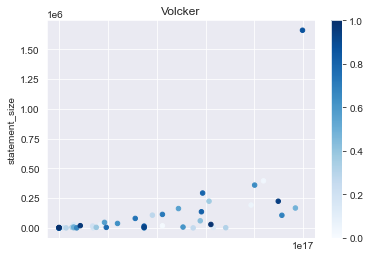

In [79]:
import seaborn as sns
df_volcker.length = df_volcker.length.astype('int')
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
df_volcker.plot.scatter(x='length', y='statement_size', c=np.linspace(0,1, len(df_volcker)), colormap='Blues')
plt.title("Volcker")

Text(0.5, 1.0, 'Greenspan')

<Figure size 1440x720 with 0 Axes>

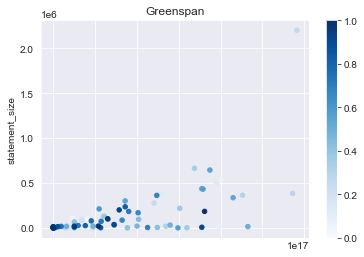

In [83]:
import seaborn as sns
df_greenspan.length = df_greenspan.length.astype('int')
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
df_greenspan.plot.scatter(x='length', y='statement_size', c=np.linspace(0,1, len(df_greenspan)), colormap='Blues')
plt.title("Greenspan")

In [137]:
df.chair_in_charge = df.chair_in_charge.astype('str')
df_yellen = df[df.chair_in_charge=='CHAIR YELLEN']
df_yellen['Date_max']=df_yellen['Date']
df_yellen = df_yellen.groupby('interlocutor_name').agg({'Date':'min', 'Date_max':'max', 'statement':' '.join})
df_yellen['statement_size']=df_yellen.statement.str.len()
df_yellen['length'] = df_yellen.Date_max.dt.date-df_yellen['Date'].dt.date

/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_22816/111669163.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yellen['Date_max']=df_yellen['Date']


In [47]:
import seaborn as sns
df_yellen.length = df_yellen.length.astype('int')
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
df_yellen.plot.scatter(x='length', y='statement_size', c=np.linspace(0,1, len(df_yellen)), colormap='Blues')
plt.title("Yellen")

NameError: name 'df_yellen' is not defined

Il n'y a apparemment pas de personnes sur les deux mandats de chair...

In [732]:
df_greenspan['length']=df_greenspan['Date_max']-df_greenspan['Date']
df_greenspan.sort_values('length', ascending=False).head()

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-732-0e1057d93709>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_greenspan['length']=df_greenspan['Date_max']-df_greenspan['Date']


,Date,Date_max,statement,length
interlocutor_name,,,,
GREENSPAN,1987-08-18,2006-01-31,longer pause expected laughter id like enterta...,6741 days
GUYNN,1987-12-16,2006-01-31,first time process fascinating economic develo...,6621 days
MATTINGLY,1989-10-03,2004-06-30,thats youd governor vote directors bank ratify...,5384 days
HOENIG,1991-10-01,2006-01-31,matter fact thats warning chairman want hear d...,5236 days
MCTEER,1991-02-06,2004-09-21,peter said authority pay interest required res...,4976 days


In [734]:
df_greenspan.sort_values('Date_max', ascending=False).head(10)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Date_max,statement,length
interlocutor_name,,,,
LACKER,2004-06-30,2006-01-31,first let add cathys commendations joe linda e...,580 days
FERGUSON,1997-11-12,2006-01-31,thank chairman already said room many reports ...,3002 days
MINEHAN,1994-03-22,2006-01-31,thank chairman trust wont either question comm...,4333 days
STRUCKMEYER,2001-06-27,2006-01-31,dan described data use analysis supply side ec...,1679 days
HOENIG,1991-10-01,2006-01-31,matter fact thats warning chairman want hear d...,5236 days
MOSKOW,1994-09-27,2006-01-31,chairman economic activity seventh district re...,4144 days
GUYNN,1987-12-16,2006-01-31,first time process fascinating economic develo...,6621 days
STOCKTON2,2006-01-31,2006-01-31,thank chairman years back noted briefings coul...,0 days
GREENSPAN,1987-08-18,2006-01-31,longer pause expected laughter id like enterta...,6741 days


In [48]:
print('Statement tandem : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_greenspan.statement, 4)

Statement tandem : 



NameError: name 'df_greenspan' is not defined

On va essayer d'implémenter une LDA sur ces individus pour le chair Greenspan et pour le chair Miller.

In [735]:
print(len(df_tandem))

0


/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [672]:
print('Statement tandem : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_tandem.statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement tandem : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.004240 -0.000112       1        1  92.414825
3      0.001094  0.000285       2        1   2.183574
2      0.001063 -0.000668       3        1   2.113081
1      0.000726  0.001188       4        1   1.644753
4      0.001356 -0.000693       5        1   1.643767, topic_info=        Term      Freq     Total Category  logprob  loglift
988    would  2.000000  2.000000  Default  30.0000  30.0000
621  percent  1.000000  1.000000  Default  29.0000  29.0000
886    think  1.000000  1.000000  Default  28.0000  28.0000
695     rate  1.000000  1.000000  Default  27.0000  27.0000
963     well  1.000000  1.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
679      put  0.011686  0.636141   Topic5  -6.7339   0.1111
510   market  0.011867  0.862259   Topic5  -6.7185  -0.1776
541    money  0.011769  0.908714   Topic5  -6.7268  -0.2384
757   saying  0.011658  0.690036   Topic5  -6.7362   0.0275
79       bad  0.011562  0.581458   Topic5  -6.7445   0.1904

[267 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
30        1  1.717208        ahead
38        1  1.165364  alternative
52        1  1.822767      appears
57        1  1.466562         area
79        1  1.719814          bad
...     ...       ...          ...
963       1  0.773802         well
988       1  0.824679        would
991       1  1.055193         year
993       1  1.131082          yes
997       1  1.506102        youre

[96 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 5])

On va implémenter une fonction cherchant les personnes 'tandem'

In [63]:
def find_overlap_chair(df, CHAIR1, CHAIR2):
    df.Date = df.Date.astype('datetime64')
    time_start = {'CHAIRMAN BURNS': '1976-08',
                'CHAIRMAN MILLER': '1978-01',
                'CHAIRMAN VOLCKER':'1979-08',
                'CHAIRMAN GREENSPAN': '1987-08',
                'CHAIRMAN BERNANKE':'2006-08',
                'CHAIR YELLEN':'2014-01'}
    time_end ={ 'CHAIRMAN BURNS': '1978-01',
                'CHAIRMAN MILLER':'1979-08',
                'CHAIRMAN VOLCKER': '1987-08',
                'CHAIRMAN GREENSPAN':'2006-08',
                'CHAIRMAN BERNANKE':'2014-01', 
                  'CHAIR YELLEN': '2016-01'}
    mask = (df.chair_in_charge == CHAIR1) + (df.chair_in_charge == CHAIR2)
    df1  = df[mask]
    df1['Date_max']= df1.Date
    df1.assign(Date_max=df1.Date)
    df_interlocutor = df1.groupby('interlocutor_name').agg({'Date':'min', 'Date_max':'max', 'statement':' '.join})
    
    mask1 = (df_interlocutor.Date.dt.strftime('%Y-%m') >= time_start[CHAIR1]) & (df_interlocutor.Date_max.dt.strftime('%Y-%m') < time_end[CHAIR1])
    mask2 = (df_interlocutor.Date.dt.strftime('%Y-%m') >= time_start[CHAIR2]) & (df_interlocutor.Date_max.dt.strftime('%Y-%m') < time_end[CHAIR2])
    mask_tandem = (df_interlocutor.Date.dt.strftime('%Y-%m') < time_start[CHAIR2]) 
    df1 = df_interlocutor[mask1]
    df2 = df_interlocutor[mask2]
    df_tandem = df_interlocutor[mask_tandem]
    
    return df1, df2, df_tandem

    

Sur Greenspan/Bernanke

In [64]:
df1, df2, df_tandem = find_overlap_chair(df, 'CHAIRMAN GREENSPAN', 'CHAIRMAN BERNANKE')


/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_49361/943076214.py:2: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  df.Date = df.Date.astype('datetime64')
/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_49361/943076214.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date_max']= df1.Date


In [751]:
df_tandem

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Date_max,statement
interlocutor_name,,,
,1996-12-17,1997-09-30,president jordan last time looked issue year a...
ALEXANDER,1999-02-03,1999-02-03,main changes forecast international side drive...
ANGELL,1987-08-18,1993-12-21,guess question ask enough billion might ask bi...
BARRON,2002-06-26,2011-01-26,thank chairman economic conditions southeast r...
BEEBE,1993-12-21,1993-12-21,statementsee appendix might add survey data ev...
...,...,...,...
WILCOX4,2002-01-30,2002-01-30,thank chairman referring material labeled staf...
WILLIAMS,2002-01-30,2014-01-29,taylor rule policymakers would need weigh dete...
WINN,1992-11-17,1999-02-03,unintelligible gonzalez staff auerbach dont kn...


In [65]:
print('Statement tandem : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_tandem.statement, 5)

Statement tandem : 



NameError: name 'pyLDAvis' is not defined

In [758]:
print('Statement Greenspan : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df1.statement, 5)


/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement tandem : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.005510  0.000016       1        1  93.478114
0     -0.000200 -0.000086       2        1   1.879818
1      0.001824 -0.001207       3        1   1.547590
4      0.001691  0.001054       4        1   1.547299
3      0.002195  0.000223       5        1   1.547179, topic_info=          Term      Freq     Total Category  logprob  loglift
988      would  4.000000  4.000000  Default  30.0000  30.0000
897      think  4.000000  4.000000  Default  29.0000  29.0000
431  inflation  3.000000  3.000000  Default  28.0000  28.0000
702       rate  3.000000  3.000000  Default  27.0000  27.0000
630    percent  3.000000  3.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
481       less  0.024366  1.519627   Topic5  -6.7289   0.0357
708     really  0.024581  1.752916   Topic5  -6.7201  -0.0983
54      around  0.024379  1.650054   Topic5  -6.7284  -0.0461
179   continue  0.024229  1.759652   Topic5  -6.7345  -0.1166
135     change  0.024124  1.800248   Topic5  -6.7389  -0.1437

[319 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2         1  0.932793  accelerating
5         1  0.921015    acceptable
8         1  0.902610           act
14        1  0.886246           add
26        1  0.804104        almost
...     ...       ...           ...
980       1  0.891312         words
988       1  0.913779         would
991       1  1.024383          year
992       1  1.109700         years
999       1  0.853051          zero

[230 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 4])

In [761]:
print('Statement Bernanke : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df2.statement, 5)


/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement Bernanke : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.002684  0.000633       1        1  80.975752
4     -0.000147 -0.002375       2        1  13.857811
3      0.001232  0.000198       3        1   1.821128
2      0.001017  0.000475       4        1   1.716798
1      0.000583  0.001069       5        1   1.628511, topic_info=          Term      Freq     Total Category  logprob  loglift
988      would  2.000000  2.000000  Default  30.0000  30.0000
426  inflation  2.000000  2.000000  Default  29.0000  29.0000
697       rate  2.000000  2.000000  Default  28.0000  28.0000
179      could  1.000000  1.000000  Default  27.0000  27.0000
513     market  2.000000  2.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
532      might  0.023400  1.523790   Topic5  -6.7061  -0.0587
426  inflation  0.023997  2.395620   Topic5  -6.6809  -0.4860
835   spending  0.023031  1.320859   Topic5  -6.7220   0.0683
697       rate  0.023715  2.453975   Topic5  -6.6927  -0.5219
965        way  0.022990  1.278026   Topic5  -6.7238   0.0995

[296 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
12        1  1.034297       actual
19        1  1.079571     advanced
26        1  1.002608        ahead
31        1  0.591493         also
32        1  0.639365  alternative
...     ...       ...          ...
982       1  0.884427      workers
988       1  1.018910        would
990       1  1.060638         year
997       1  0.651039       yields
998       1  0.997070        youre

[216 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 3, 2])

In [766]:
df1, df2, df_tandem = find_overlap_chair(df, 'CHAIRMAN BERNANKE', 'CHAIR YELLEN')

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-765-01c49b146531>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date_max']= df1.Date


In [768]:
print('Statement tandem : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_tandem.statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement tandem : 



PreparedData(topic_coordinates=              x             y  topics  cluster       Freq
topic                                                    
1      0.019042 -5.467355e-07       1        1  94.391558
4     -0.006301  1.063462e-03       2        1   1.426999
3     -0.001120  1.023700e-04       3        1   1.394967
2     -0.005266 -5.319513e-04       4        1   1.393387
0     -0.006355 -6.333342e-04       5        1   1.393088, topic_info=          Term       Freq      Total Category  logprob  loglift
424  inflation  14.000000  14.000000  Default  30.0000  30.0000
988      would  14.000000  14.000000  Default  29.0000  29.0000
697       rate  12.000000  12.000000  Default  28.0000  28.0000
624    percent  10.000000  10.000000  Default  27.0000  27.0000
609      panel   8.000000   8.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
141  committee   0.039351   5.215558   Topic5  -6.7328  -0.6132
517    markets   0.039256   5.288671   Topic5  -6.7352  -0.6296
522        may   0.039189   5.940300   Topic5  -6.7369  -0.7475
424  inflation   0.039455  14.522014   Topic5  -6.7301  -1.6346
179      could   0.038731   6.787655   Topic5  -6.7486  -0.8926

[364 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  1.203193        ability
2         1  1.056540  accommodation
6         1  0.680953        achieve
8         1  0.866912            act
14        1  0.853385            add
...     ...       ...            ...
990       1  0.984893           year
991       1  0.977033          years
992       1  0.845200         yellen
993       1  0.874910            yes
997       1  0.760099         yields

[239 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 3, 1])

In [769]:
print('Statement Bernanke : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df1.statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement Bernanke : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.005961 -0.000012       1        1  93.397995
4      0.001140  0.000955       2        1   1.742493
2      0.001554  0.000405       3        1   1.653852
1      0.001283 -0.001261       4        1   1.632528
3      0.001984 -0.000087       5        1   1.573132, topic_info=          Term      Freq     Total Category  logprob  loglift
988      would  4.000000  4.000000  Default  30.0000  30.0000
433  inflation  4.000000  4.000000  Default  29.0000  29.0000
703       rate  3.000000  3.000000  Default  28.0000  28.0000
624    percent  3.000000  3.000000  Default  27.0000  27.0000
636     policy  2.000000  2.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
191     credit  0.025552  2.041852   Topic5  -6.7192  -0.2288
575   november  0.025029  1.368905   Topic5  -6.7399   0.1504
778        say  0.025058  1.467879   Topic5  -6.7387   0.0817
179       core  0.025054  1.727199   Topic5  -6.7389  -0.0811
926        top  0.024963  1.749274   Topic5  -6.7425  -0.0975

[302 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
12        1  0.974916      actual
19        1  0.987832  adjustment
25        1  0.913460       agree
26        1  1.069924   agreement
30        1  0.789993       along
...     ...       ...         ...
985       1  1.045938     worried
988       1  0.883502       would
990       1  1.063342        year
997       1  0.803390        york
998       1  0.921603       youre

[217 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4])

In [770]:
print('Statement Yellen : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df2.statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement Yellen : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.000776  0.000624       1        1  71.160160
1     -0.001027 -0.000456       2        1  24.394987
4      0.000621  0.000712       3        1   1.482208
2      0.000668  0.000171       4        1   1.481499
3      0.000514 -0.001051       5        1   1.481146, topic_info=               Term      Freq     Total Category  logprob  loglift
809           slack  0.000000  0.000000  Default  30.0000  30.0000
280      everything  0.000000  0.000000  Default  29.0000  29.0000
163  considerations  0.000000  0.000000  Default  28.0000  28.0000
362          growth  0.000000  0.000000  Default  27.0000  27.0000
794            side  0.000000  0.000000  Default  26.0000  26.0000
..              ...       ...       ...      ...      ...      ...
874            tell  0.002028  0.115257   Topic5  -6.7373   0.1720
584         outlook  0.002041  0.126112   Topic5  -6.7309   0.0884
429       investors  0.002018  0.113332   Topic5  -6.7418   0.1844
179         correct  0.002018  0.119752   Topic5  -6.7418   0.1293
135            come  0.002021  0.124318   Topic5  -6.7407   0.0929

[270 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 3, 4])

Semblerait-il qu'il y ait un effet du changement de chair sur les topics abordés. On dénote 2 topics principaux sous la chair Yellen contre 1 seul dominant sous Bernanke pour les individus présents sous les deux chair. 

#### Approche avec *word2vec*

### Novelty and transience

$ s^{(j)} = (s_i^{(j)})_i $ list of $ S$ speech topic mixtures with $j$ the chronological order and $i$ the topic. 
- KLD (Kullback Leibler divergence) :
$$ KLD(p|q) = \int_X p \log \frac{p}{q} d\mu $$
- Novelty : 
$$ \mathcal{N}(j) = \frac{1}{w} \sum_{d=1}^w KLD(s^{(j)} | s^{(j-d)})$$ 
- Resonance :
$$ \mathcal{R}(j) =  \frac{1}{w} \big[ \sum_{d=1}^w KLD(s^{(j)} | s^{(j-d)}) - KLD(s^{(j)} | s^{(j+d)}) \big] $$

In [8]:
# Create the list of speech topic mixtures
# Let's see novelty and transience in Greenspan vs Bernanke's speeches.

In [39]:
greenspan = df[df.chair_in_charge == 'CHAIRMAN GREENSPAN']
bernanke = df[df.chair_in_charge =='CHAIRMAN BERNANKE']

Because one person's speech is too short compared to the PNAS experiment, we'll consider the whole intervention of each individual as a speech.

In [40]:
GP = greenspan.groupby('interlocutor_name').agg({'statement _size':'sum', 'statement':' '.join})

In [54]:
speech_Bernanke = GP.loc['BERNANKE'].statement.lower().split()

In [55]:
KLD(speech_Bernanke[10, 15])

TypeError: list indices must be integers or slices, not tuple

GP

In [6]:
def KLD(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [ ]:
def novelty(j, w=50) :
    